<a href="https://colab.research.google.com/github/3BR22AI066/RESNET/blob/main/chapter_appendix-tools-for-deep-learning/jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow keras numpy pandas matplotlib scikit-learn opencv-python

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
import kagglehub

path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'covid19-radiography-database' dataset.
Path to dataset files: /kaggle/input/covid19-radiography-database


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_dir = "/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5"

base_dir = "dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

categories = []


In [6]:
import os

dataset_dir = "/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5"

for root, dirs, files in os.walk(dataset_dir):
    if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in files):
        print(f" Found images in: {root}")
        print(f" Example files: {files[:3]}")
        break


In [7]:
import os
import shutil
from sklearn.model_selection import train_test_split


dataset_dir = "/kaggle/input/covid19-radiography-database"
source_base_dir = os.path.join(dataset_dir, "COVID-19_Radiography_Dataset")

train_dir = "dataset/train"
test_dir = "dataset/test"

if os.path.exists("dataset"):
    shutil.rmtree("dataset")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

categories = [d for d in os.listdir(source_base_dir) if os.path.isdir(os.path.join(source_base_dir, d))]

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

for category in categories:

    source_dir = os.path.join(source_base_dir, category, "images")

    if not os.path.exists(source_dir):
        print(f" Folder not found: {source_dir}")
        continue

    images = [f for f in os.listdir(source_dir)
              if os.path.isfile(os.path.join(source_dir, f)) and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if images:

        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        for img in train_images:
            shutil.copy(os.path.join(source_dir, img), os.path.join(train_dir, category, img))

        for img in test_images:
            shutil.copy(os.path.join(source_dir, img), os.path.join(test_dir, category, img))

        print(f" {category}: {len(train_images)} train | {len(test_images)} test images copied.")
    else:
        print(f" No images found in {source_dir}")

print("\n Dataset successfully split into training and testing folders!")

 Normal: 8153 train | 2039 test images copied.
 Lung_Opacity: 4809 train | 1203 test images copied.
 Viral Pneumonia: 1076 train | 269 test images copied.
 COVID: 2892 train | 724 test images copied.

 Dataset successfully split into training and testing folders!


In [9]:
import os
import warnings
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils import class_weight
import numpy as np


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore", category=UserWarning, module="keras")
warnings.filterwarnings("ignore", category=FutureWarning)

print("🔧 All warnings suppressed. Training ResNet50...")

train_dir = 'dataset/train'
test_dir = 'dataset/test'


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:140]:
    layer.trainable = False
for layer in base_model.layers[140:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

classes = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(classes),
    y=classes
)
class_weights = dict(enumerate(class_weights))
print("\n📊 Class Weights:", class_weights)

optimizer = Adam(learning_rate=1e-4)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint("best_resnet50_covid_model.keras", save_best_only=True, monitor='val_accuracy', mode='max')  # ✅ new format
]

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

model.save("covid_resnet50_regularized_model.keras")
print("\nModel retrained and saved as covid_resnet50_regularized_model.keras (no warnings).")


🔧 All warnings suppressed. Training ResNet50...
Found 16930 images belonging to 4 classes.
Found 4235 images belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

📊 Class Weights: {0: np.float64(1.4635200553250345), 1: np.float64(0.880120607194843), 2: np.float64(0.5191340610818104), 3: np.float64(3.933550185873606)}
Epoch 1/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 324s 561ms/step - accuracy: 0.3772 - loss: 1.4525 - val_accuracy: 0.4803 - val_loss: 1.7770 - learning_rate: 1.0000e-04
Epoch 2/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 277s 523ms/step - accuracy: 0.4940 - loss: 1.0419 - val_accuracy: 0.4730 - val_loss: 3.2521 - learning_rate: 1.0000e-04
Epoch 3/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 280s 529ms/step - accuracy: 0.5462 - loss: 0.9599 - val_accuracy: 0.5648 - val_loss: 1.1577 - learning_rate: 1.0000e-04
Epoch 4/30
530/530 ━━━━━━━━━━━━━━━━━━━━ 279s 526ms/step - accuracy: 0.5613 - loss: 0.9221 - val_accuracy: 0.5724 - val_loss: 1.3125 - learning_rate: 1.0000e-04
Epoch 5/30
530/530 

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 57,104,526 (217.84 MB)

 Trainable params: 16,163,588 (61.66 MB)

 Non-trainable params: 8,613,760 (32.86 MB)

 Optimizer params: 32,327,178 (123.32 MB)

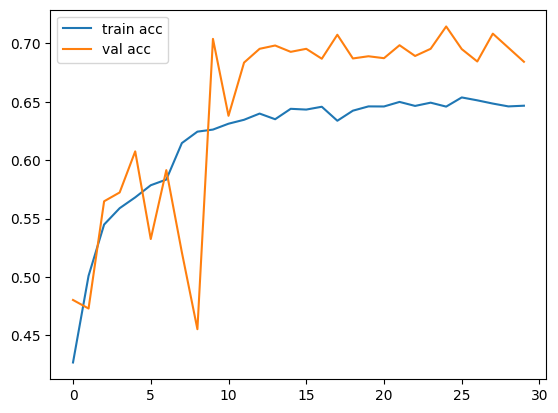

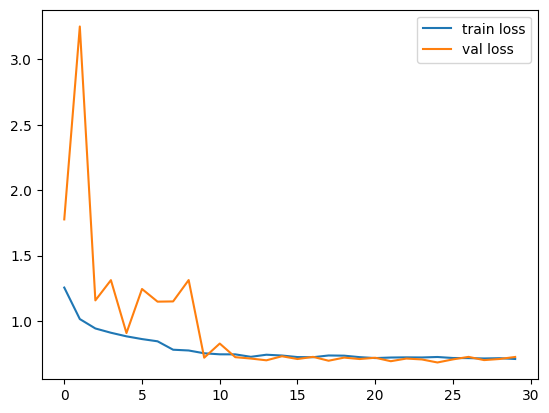

In [11]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [12]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import os

# Load the correct model file
model = load_model("covid_resnet50_regularized_model.keras")


covid_test_dir = 'dataset/test/COVID'

covid_test_images = [f for f in os.listdir(covid_test_dir) if os.path.isfile(os.path.join(covid_test_dir, f))]

if covid_test_images:
    img_path = os.path.join(covid_test_dir, covid_test_images[0]) # Use the first image found
    print(f"Using image: {img_path}")

    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    class_indices = {
        'COVID': 0,
        'Lung_Opacity': 1,
        'Normal': 2,
        'Viral Pneumonia': 3
    }

    predicted_class = list(class_indices.keys())[np.argmax(prediction)]
    confidence = np.max(prediction)

    print(f"Predicted: {predicted_class} (Confidence: {confidence*100:.2f}%)")

Using image: dataset/test/COVID/COVID-1972.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted: COVID (Confidence: 77.78%)


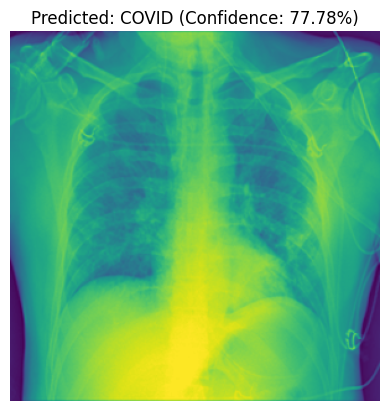

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class} (Confidence: {confidence*100:.2f}%)")
plt.show()

Saving covid_pic.jpeg to covid_pic.jpeg
User uploaded file "covid_pic.jpeg" with length 4779 bytes
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


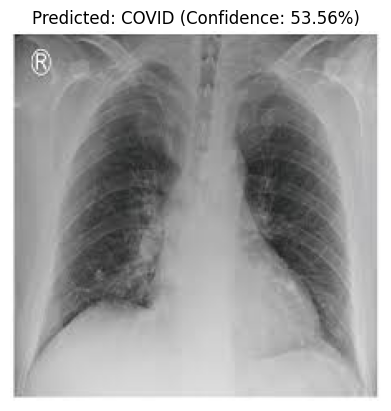

In [14]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model

# Load the correct model file
model = load_model("covid_resnet50_regularized_model.keras")

class_labels = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

def predict_uploaded_image(filepath):
    """Predicts the class of an uploaded image."""
    img = image.load_img(filepath, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_index]
    confidence = np.max(prediction)


    img_display = mpimg.imread(filepath)
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} (Confidence: {confidence*100:.2f}%)")
    plt.show()


uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

    predict_uploaded_image(fn)

In [15]:
model.save("final_resnet50_covid_model.keras")

In [18]:
from google.colab import files
files.download('final_resnet50_covid_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import os
os.listdir()

['.config',
 'final_resnet50_covid_model.keras',
 'best_resnet50_covid_model.keras',
 'covid_resnet50_regularized_model.keras',
 'covid_pic.jpeg',
 '.git',
 'dataset',
 'sample_data']

In [20]:
from google.colab import files

files.download('best_resnet50_covid_model.keras')
files.download('covid_resnet50_regularized_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>